In [33]:
import numpy as np
import gzip
import theano
from keras.models import load_model
from keras.models import Model
import tensorflow as tf

In [34]:
def get_test():
    
    f = open('datasetTranskay/cb513+profile_split1.npy.gz', 'rb')
    cb513 = np.load(f)
    cb513 = np.reshape(cb513, (514, 700, 57))
    cb513 = cb513[:, :, :].astype(theano.config.floatX)

    return cb513

In [35]:
cb513 = get_test()

In [ ]:
for i in range(700):
    print(cb513[0,i,0:21])
    print(cb513[0,i,22:30])
    if(cb513[0,i,0:21].sum() == 0):
        print(i)
    if(cb513[0,i,22:30].sum() == 0):
        print(i)        

In [ ]:
path = "allDataset_assembly/model-assembly-all-30epochs-0.hdf5"
m = load_model( path )

In [15]:
from IPython.display import clear_output
import random

allValidWindows = []
all_targets = []

for i in range(cb513.shape[0]):
    
    print("protein nr " ,i)
    clear_output(wait=True)
    
    lastIndex = 700
    #ground truth
    for k in range(700):
        ground_truth = cb513[i,k,22:30]
        if(ground_truth.sum() == 0):
            lastIndex = k
            break
        all_targets.append(ground_truth)

    #creating padding version so we do not loose information
    padded = np.zeros((700+18, 57))
    padded[9:709] = cb513[i]
    
    for k in range(9):
        #padded[8-k] = cb513[i, lastIndex - 1 - k]
        padded[k] = cb513[i,0]#cb513[i,random.randint(0, lastIndex - 1)]#  #0# #
    
    nexta = 0
    for k in range(lastIndex + 9 , lastIndex + 9 + 9):
        #padded[k] = 0# cb513[i, 0 + nexta]
        nexta += 1
        padded[k] = 0#cb513[i,random.randint(0, lastIndex - 1)]#cb513[i,lastIndex - 1]##
        
    
    #making predictions
    predictions = []
    for k in range(718 - 19 + 1):

        if cb513[i,k,0:21].sum() == 0:
            break
        #make sure to check PSSM or 1 hot
        window =  padded[k:k+19, 35:56]
        allValidWindows.append(window)

protein nr  513


In [ ]:
scores = m.evaluate(np.array(allValidWindows), np.array(all_targets))
print("Loss: " + str(scores[0]) + ", Accuracy: " + str(scores[1]) + ", MAE: " + str(scores[2]))

In [16]:
from sklearn.metrics import accuracy_score
def get_accuracy(all_targets, all_pred ):
    
    all_targets = np.array(all_targets)

    final_pred = []
    final_target = []
    for i in range(len(allValidWindows)):
        final_pred.append( np.argmax(all_pred[i]))
        final_target.append( np.argmax(all_targets[i]))
        
    res = accuracy_score(final_pred, np.array(final_target))     
    print(res)
    return res

In [17]:
def sum_predictions(window_preds):
    return sum(window_preds, 0)
def average_predictions(window_preds):
    return np.average(window_preds, 0)
def max_predictions(window_preds):
    return np.max(window_preds, 0)

In [19]:
## model assembly cb513 accuracy
def get_stacked_predictions(allValidWindows, nr_models):
    
    stacked_predictions = []
    
    for i in range (nr_models):
    
        path = 'allDataset_assembly/model-assmebly-' + str(i) + '.hdf5'
        m = load_model( path )
        print("model " , i)
        predictions  = m.predict(allValidWindows, verbose = 1)
        acc = get_accuracy(all_targets, np.array(predictions) )
        stacked_predictions.append(predictions)
    
    for i in range (4):
    
        path = 'allDataset_assembly/model-assembly-all-75epochs-' + str(i) + '.hdf5'
        m = load_model( path )
        print("model " , i)
        predictions  = m.predict(allValidWindows, verbose = 1)
        acc = get_accuracy(all_targets, np.array(predictions) )
        stacked_predictions.append(predictions)
    
     
    return np.array(stacked_predictions)

nr_models = 12
allValidWindows = np.array(allValidWindows)
stacked_predictions = get_stacked_predictions(allValidWindows, nr_models)

model  0
84765/84765 [==============================] - 51s 606us/step
0.6998997227629328
model  1
84765/84765 [==============================] - 54s 642us/step
0.7006547513714387
model  2
84765/84765 [==============================] - 76s 898us/step
0.7006547513714387
model  3
84765/84765 [==============================] - 79s 934us/step
0.6999351147289565
model  4
84765/84765 [==============================] - 76s 891us/step
0.699628384356751
model  5
84765/84765 [==============================] - 79s 931us/step
0.6996637763227748
model  6
84765/84765 [==============================] - 73s 863us/step
0.6991800861204507
model  7
84765/84765 [==============================] - 67s 792us/step
0.6993452486285613
model  8
84765/84765 [==============================] - 69s 809us/step
0.6990503155783637
model  9
84765/84765 [==============================] - 74s 872us/step
0.6989323423582847
model  10
84765/84765 [==============================] - 72s 844us/step
0.6983542735798973
model  11


In [20]:
assembly_pred = []    
for i in range(allValidWindows.shape[0]):

    print("now in func")
    print("window nr " ,i)
    clear_output(wait=True)
    
    window_preds = stacked_predictions[:,i]
    window_pred = average_predictions(window_preds)
    assembly_pred.append(window_pred)
    
assembly_pred = np.array(assembly_pred)    

now in func
window nr  84764


In [21]:
print(stacked_predictions.shape)
acc = get_accuracy(all_targets, assembly_pred )

(16, 84765, 8)
0.7095027428773668


In [ ]:
# 0.707756739220197 - 4 models all dataset - average
# 0.7093021884032324 - 12 models all dataset - average
# 0.7042883265498732 - 2 models all dataset - average
# 0.7093729723352798 - 16 models all dataset - average - with 30 epochs
# 0.7095027428773668 - 16 models all dataset - average - with 75 epochs

#0.707391022237952 -  15 models with valid split
# 0.7066949802394856 - 4 models with valid split


#0.7091842151831534 all 24

43   0.6996637763178525


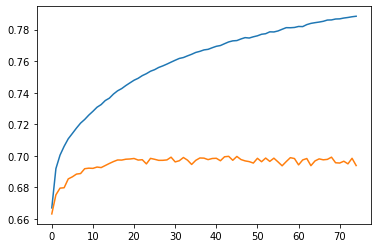

In [29]:
import matplotlib.pyplot as plt
import pickle

m1H1 = pickle.load( open( "allDataset_assembly/model-assembly-all-hist-75epochs-3", "rb" ) )
# Plot training & validation accuracy values


a = np.array(m1H1['val_acc'])
inde = np.argmax(a)
x = m1H1['val_acc'][inde]
print(inde, " ", x)


plt.plot(m1H1['acc'])
plt.plot(m1H1['val_acc'])


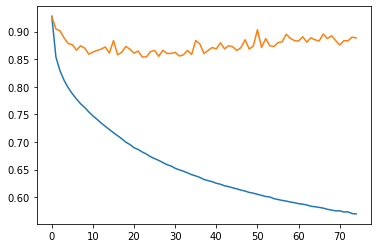

In [24]:
plt.plot(m1H1['loss'])
plt.plot(m1H1['val_loss'])

30.0


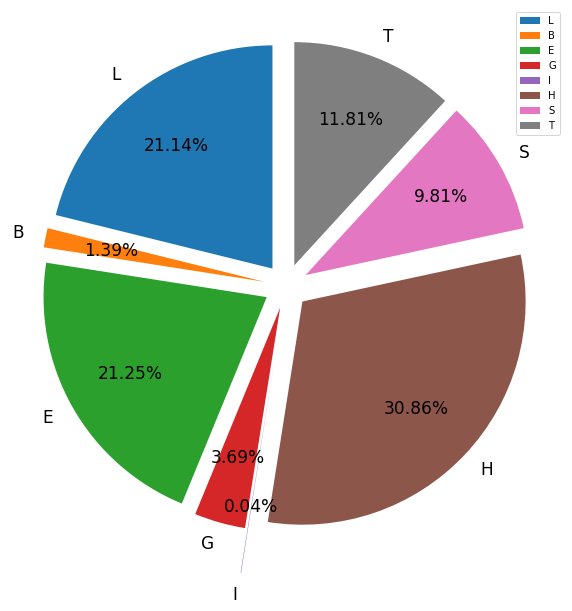

In [111]:
import matplotlib.pyplot as plt


sizes = np.zeros(8)
for i in range(cb513.shape[0]):
    for j in range(cb513.shape[1]):
        if cb513[i,j,22:30].sum() != 0:
            index = cb513[i,j,22:30].argmax()
            sizes[index] += 1
        
print(sizes[4])
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = 'L', 'B', 'E', 'G', 'I', 'H', 'S', 'T'
explode = (0.1, 0.1, 0.1, 0.1, 0.3, 0.1,0.1, 0.1)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
fig1.set_size_inches(10,15)
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.2f%%', startangle=90, pctdistance  = 0.7, textprops={'fontsize': 17})

plt.legend()

plt.savefig("cb513pie", bbox_inches = 'tight',
    pad_inches = 0)
plt.show()